**Question 1**

In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 30.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
env = gym.make('FrozenLake-v1', desc=desc, map_name="4x4", is_slippery=True)

The SARSA algorithm

In [ ]:
epsilon = 0.9
total_episodes = 10
max_steps = 100
alpha = 0.85
gamma = 0.95
temperature = 10
#Initializing the Q-matrix
Q = np.zeros((env.observation_space.n, env.action_space.n))

In [ ]:

#Function to choose the next action
def boltzmann_exploration(Q, state, temperature):
    Z = Q[state]/temperature - np.max(Q[state]/temperature) #to stabilize for low temperatures
    exp_values = np.exp(Z)
    p = exp_values / np.sum(exp_values)
    actions = np.array(range(4))
    return np.random.choice(actions,p=p)



In [ ]:

def sarsa(Q,env,total_episodes,temperature,alpha,gamma):
  rewards = []

  for episode in range(total_episodes):
      done = False
      state1 = env.reset()[0]
      rewards_eps = []
      action1 = boltzmann_exploration(Q,state1,temperature)

      while not done :
          #Visualizing the training

          #Getting the next state
          state2, reward, done1,done2, info = env.step(action1)
          done = done1 or done2
          #Choosing the next action
          action2 = boltzmann_exploration(Q,state2,temperature)


          predict = Q[state1, action1]
          target = reward + gamma * Q[state2, action2]
          Q[state1, action1] = Q[state1, action1] + alpha * (target - predict)

          state1 = state2
          action1 = action2
          rewards_eps.append(reward)
      #discounted_rewards = [rewards_eps[i]*gamma**i for i in range(len(rewards_eps))]
      rewards.append(sum(rewards_eps))
  return Q,rewards/num_episodes



In [ ]:
def testing (Q,env):
  state = env.reset()[0]
  action = np.argmax(Q[state])
  stop_arrive = False
  reward = 0
  while not stop_arrive:
    action = np.argmax(Q[state])
    next_state,rew,done1,done2,_ = env.step(action)
    stop_arrive = done1 or done2
    state = next_state
    reward = gamma*reward + rew

  return reward


In [ ]:
# Run the experiments
dicti_SARSA = {}
dicti_SARSA_learning_plot = {}
dicti_SARSA_testing_plot = {}
gamma = 0.9
num_runs  = 10
num_segments = 500
num_training_episodes = 10
for alpha in [0.01,0.5,0.8]:
  for temperature in [0.01,0.001,0.0001]:

    rewards_runs_test = []
    rewards_runs_train = []
    for run in tqdm(range(num_runs)):
        rewards_tst = []
        rewards_train = []
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        for segment in (range(num_segments)):
          Q,reward_train = sarsa(Q,env,num_training_episodes,temperature,alpha,gamma)
          reward_train = reward_train
          #testing on the last 11-th run
          reward_test = testing(Q,env)
          rewards_tst.append(reward_test)
          rewards_train.append(reward_train)
        rewards_runs_test.append(rewards_tst)
        rewards_runs_train.append(rewards_train)
    t = np.array(rewards_runs_train)
    c = np.mean(t,axis=0)
    dicti_SARSA[str((temperature,alpha))] = np.mean(t[:,-1])
    dicti_SARSA_learning_plot[str((temperature,alpha))] = c
    dicti_SARSA_testing_plot[str((temperature,alpha))] = rewards_runs_test







100%|██████████| 10/10 [02:29<00:00, 14.97s/it]


In [ ]:
import pickle
with open('SARSA1.pkl', 'wb') as f:
    pickle.dump(dicti_SARSA, f)
with open('SARSA1_learn.pkl', 'wb') as f:
    pickle.dump(dicti_SARSA_learning_plot, f)
with open('SARSA1_test.pkl', 'wb') as f:
    pickle.dump(dicti_SARSA_testing_plot, f)

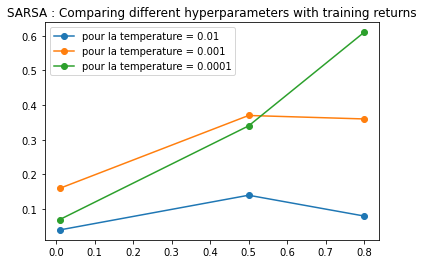

In [ ]:
#draw the plots.
plot = []

for temperature in [0.01,0.001,0.0001]:
  plot_temperature = []
  for alpha in [0.01,0.5,0.8]:
    plot_temperature.append(dicti_SARSA[str((temperature,alpha))])
  plt.plot([0.01,0.5,0.8],plot_temperature, label = "pour la temperature = {}".format(temperature),marker = 'o')
plt.legend()
plt.title("SARSA : Comparing different hyperparameters with training returns" )
plt.show()


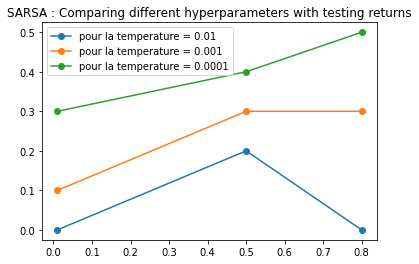

In [ ]:
#draw the plots.
plot = []
for temperature in [0.01,0.001,0.0001]:
  plot_temperature = []
  for alpha in [0.01,0.5,0.8]:
    k = dicti_SARSA_testing_plot[str((temperature,alpha))]
    t = np.array(k)
    test = np.mean(t,axis=0)
    plot_temperature.append(test[-1])
  plt.plot([0.01,0.5,0.8],plot_temperature, label = "pour la temperature = {}".format(temperature),marker = 'o')
plt.title("SARSA : Comparing different hyperparameters with testing returns" )
plt.legend()
plt.show()

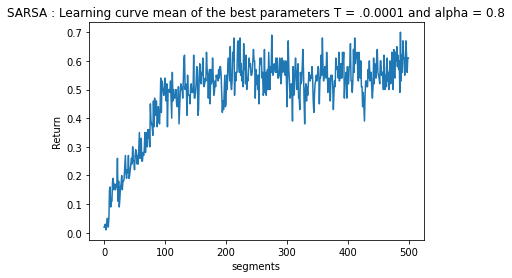

In [ ]:
#plot the best learning_curve for SARSA
best_parameters = (0.0001,0.8)
plot = dicti_SARSA_learning_plot[str(best_parameters)]
plot = np.array(plot)
mean = np.mean(plot,axis= 1)
plt.plot(mean)
plt.xlabel("segments")
plt.ylabel("Return")
plt.title("SARSA : Learning curve mean of the best parameters T = .{} and alpha = {}".format(0.0001,0.8))
plt.show()


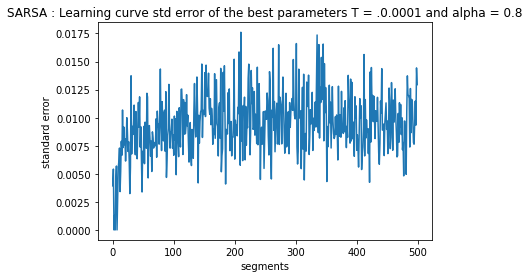

In [ ]:
#plot the best learning_curve for SARSA
best_parameters = (0.0001,0.8)
plot = dicti_SARSA_learning_plot[str(best_parameters)]
plot = np.array(plot)
mean = np.std(plot,axis= 1)/np.sqrt(10)
plt.plot(mean)
plt.xlabel("segments")
plt.ylabel("standard error")
plt.title("SARSA : Learning curve std error of the best parameters T = .{} and alpha = {}".format(0.0001,0.8))
plt.show()

Expected SARSA

In [ ]:
def expectation_q(Q,state,epsilon):
  E = 0
  best_action = np.argmax(Q[state])
  for action in range(4):
    if action == best_action :
      E += (1 - epsilon + epsilon/4)*Q[state,action]
    else:
      E += Q[state,action]*epsilon/4
  return E



In [ ]:
def expected_sarsa(Q,env,total_episodes,temperature,alpha,gamma,epsilon):
  rewards = []

  for episode in range(total_episodes):
      done = False
      state1 = env.reset()[0]

      action1 = boltzmann_exploration(Q,state1,temperature)
      rewards_eps = []
      while not done :
          #Visualizing the training

          #Getting the next state
          state2, reward, done1,done2, info = env.step(action1)
          done = done1 or done2
          #Choosing the next action
          action2 = boltzmann_exploration(Q,state2,temperature)

          #Learning the Q-value REDO
          E = expectation_q(Q,state2,epsilon)
          predict = Q[state1,action1]
          target = reward + gamma * E
          Q[state1, action1] = Q[state1, action1] + alpha * (target - predict)

          state1 = state2
          action1 = action2
          rewards_eps.append(reward)
      discounted_rewards = [rewards_eps[i]*gamma**i for i in range(len(rewards_eps))]
      rewards.append(sum(discounted_rewards))
  return Q,rewards

In [ ]:
# Run the experiments
dicti_SARSA = {}
dicti_SARSA_learning_plot = {}
dicti_SARSA_testing_plot = {}
gamma = 0.9
epsilon = 0.05
num_runs  = 10
num_segments = 500
num_training_episodes = 10
for alpha in [0.01,0.5,0.8]:
  for temperature in [0.01,0.001,0.0001]:

    rewards_runs_test = []
    rewards_runs_train = []
    for run in tqdm(range(num_runs)):
        rewards_tst = []
        rewards_train = []
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        for segment in (range(num_segments)):
          Q,reward_train = expected_sarsa(Q,env,num_training_episodes,temperature,alpha,gamma,epsilon)
          reward_train = reward_train
          #testing on the last 11-th run
          reward_test = testing(Q,env)
          rewards_tst.append(reward_test)
          rewards_train.append(reward_train)
        rewards_runs_test.append(rewards_tst)
        rewards_runs_train.append(rewards_train)
    t = np.array(rewards_runs_train)
    c = np.mean(t,axis=0)
    dicti_SARSA[str((temperature,alpha))] = np.mean(t[:,-1])
    dicti_SARSA_learning_plot[str((temperature,alpha))] = c
    dicti_SARSA_testing_plot[str((temperature,alpha))] = rewards_runs_test

100%|██████████| 10/10 [02:30<00:00, 15.07s/it]


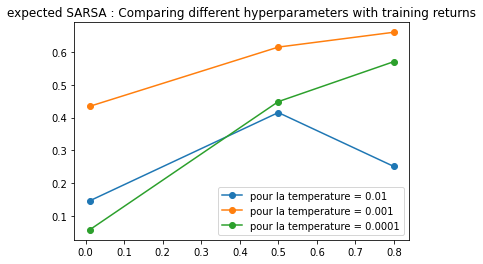

In [ ]:
#draw the plots.
plot = []

for temperature in [0.01,0.001,0.0001]:
  plot_temperature = []
  for alpha in [0.01,0.5,0.8]:
    plot_temperature.append(dicti_SARSA[str((temperature,alpha))])
  plt.plot([0.01,0.5,0.8],plot_temperature, label = "pour la temperature = {}".format(temperature),marker = 'o')
plt.legend()
plt.title("expected SARSA : Comparing different hyperparameters with training returns" )
plt.show()

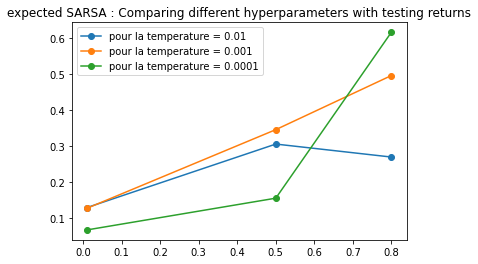

In [ ]:
#draw the plots.
plot = []
for temperature in [0.01,0.001,0.0001]:
  plot_temperature = []
  for alpha in [0.01,0.5,0.8]:
    k = dicti_SARSA_testing_plot[str((temperature,alpha))]
    t = np.array(k)
    test = np.mean(t,axis=1)
    plot_temperature.append(test[-1])
  plt.plot([0.01,0.5,0.8],plot_temperature, label = "pour la temperature = {}".format(temperature),marker = 'o')
plt.title("expected SARSA : Comparing different hyperparameters with testing returns" )
plt.legend()
plt.show()

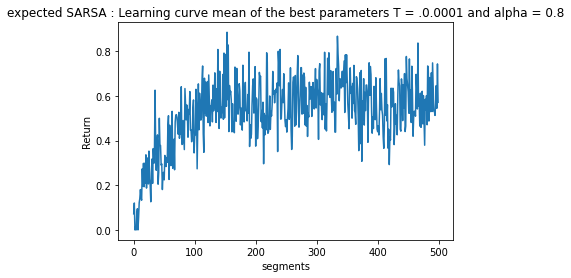

In [ ]:
#plot the best learning_curve for SARSA
best_parameters = (0.0001,0.8)
plot = dicti_SARSA_learning_plot[str(best_parameters)]
plot = np.array(plot)
mean = 10*np.mean(plot,axis= 1)
plt.plot(mean)
plt.xlabel("segments")
plt.ylabel("Return")
plt.title("expected SARSA : Learning curve mean of the best parameters T = .{} and alpha = {}".format(0.0001,0.8))
plt.show()

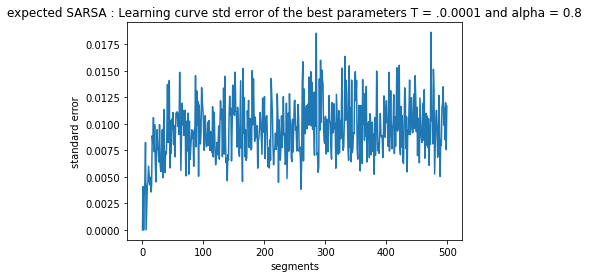

In [ ]:
#plot the best learning_curve for SARSA
best_parameters = (0.001,0.8)
plot = dicti_SARSA_learning_plot[str(best_parameters)]
plot = np.array(plot)
mean = np.std(plot,axis= 1)/np.sqrt(10)
plt.plot(mean)
plt.xlabel("segments")
plt.ylabel("standard error")
plt.title("expected SARSA : Learning curve std error of the best parameters T = .{} and alpha = {}".format(0.0001,0.8))
plt.show()

**The choice of return**

the return here is the sum of the discounted rewards with gamma, one has to observe that for gamma very close to one (as the one chosen) the sum is very close from the discounted sum.


Also the advantage of the returns as just a sum rewards is that it is easy to interpret. Achieving 0.6 in returns means that the algorithm predicts 60% of the time a working strategy to succeed the task in hand.

**SARSA**
The choice of the parameters is done based on the best learning and testing perdormance. The best parameters are the ones given by temperature = 0.0001 and alpha = 0.8

**The choice of the temperature**
The choice of the lowest temperature  makes sense here,since for the boltzman exploration the lowest is the temperature the further we are from a uniform distribution of the action over a given state. A very high temperature comes back to chosing uniformly between the four actions.


**The choice of the learning rate**
a high learning rate means that we achieve the global extremum in very few steps (the jumps from one sstep to another is considerable when lr = alpha is great). So here we avoid the local extrema as well, since a small learning rate can converge after a high number of steps, but can be stuck in a local extremum.

**Expected SARSA** In what comes to expected sarsa I have put epsilon to be 0.05 so that the expectation that is calculated for the expected SARSA update manly is the value of the best action, which enhances the performance of expected SARSA.

**Best Parameters**
Here the best parameters are the same as SARSA. so therefore the same explanation. Also the Expected SARSA does perform better than the SARSA. Best testing performance for expeted SARSA is 0.6. and best testing performance for SARSA being aroung 0.5

**Learning curves** The learning curves of SARSA at the end are around 0.5 -0.6 - 0.7 which is a quite good performace. and for Expected SARSA is surpasses that to some values around 0.8 even (0.9 - 1.0) are also in the values.

This might seem shocking with what the last learning and testing gave (0.5 - 0.6), but actually makes sense since the standard error is quite high around the end of the learning curve.



**Question 2**

In [ ]:
env2 = gym.make('CartPole-v1')
num_bins = 10

lower_bounds = env2.observation_space.low
upper_bounds = env2.observation_space.high
lower_bounds[1] = -3
lower_bounds[-1] = -3
upper_bounds[1] = 3
upper_bounds[-1] = 3


def one_hot_encode(state):
  bins = [
      np.linspace(lower,upper,num_bins+1)[1:]
      for (lower,upper) in zip(lower_bounds,upper_bounds)
  ]
  x = np.clip(state,lower_bounds,upper_bounds)
  idx = [np.digitize(x_i,b_i,right = True) for (x_i,b_i) in zip(x,bins)]
  one_hots = [np.eye(num_bins)[i] for i in idx]
  return np.concatenate(one_hots)


def eps_greedy_policy(W,state,eps):
    u = np.random.uniform(0,1)
    if u < eps :
      action = np.random.randint(low= 0,high =1)
    else :
      action = np.argmax(one_hot_encode(state).dot(W))
    return action

def boltzmann_exploration_w(W, state, temperature):
    q_state = np.dot(np.transpose(W),state)
    Z = q_state/temperature - np.max(q_state/temperature)
    exp_values = np.exp(Z)
    p = exp_values / np.sum(exp_values)
    actions = np.array(range(2))
    return np.random.choice(actions,p=p)


In [ ]:
1/16

0.0625

In [ ]:
class Qlearning:
  def __init__(
    self,
    num_actions : int,
    gamma : float = 0.99,
    alpha: float = 1./16,
    epsilon: float = 0.1
  ):
    self.num_actions = num_actions
    self.gamma = gamma
    self.alpha = alpha
    self.epsilon = epsilon
    self.w = np.random.uniform(-0.001,0.001,size=(4*num_bins,self.num_actions))

  def action(self,x,train = True):
    if train and (np.random.uniform() <= self.epsilon):
      return np.random.choice(self.num_actions)
    qs = one_hot_encode(x).dot(self.w)
    return np.argmax(qs)

  def update(self,x,a,r,nx,d):
    next_qs = one_hot_encode(nx).dot(self.w)
    next_v = np.max(next_qs)
    target = r + self.gamma*next_v*(1-d)
    phi_x = one_hot_encode(x)
    q = phi_x.dot(self.w)[a]
    dw = (q - target)*phi_x
    self.w[:,a] -= self.alpha*dw

In [ ]:
def rollout(agent,env,train = True, render = False):
  score = 0
  x,_ = env.reset()
  if render :
    env.render()
  d = False
  while not d:
    a = agent.action(x,train = train)
    nx,r,d1,d2,_ = env.step(a)
    if render:
      env.render()
    if train :
      agent.update(x,a,r,nx,d1)
    d = d1 or d2
    x = nx
    score += r
  return score

In [ ]:
b = []
for run in range(10):
  agent = Qlearning(2)
  d = []
  for ep in tqdm(range(1000)):
      d.append((rollout(agent,env2)))
  b.append(d)


100%|██████████| 1000/1000 [01:06<00:00, 15.07it/s]


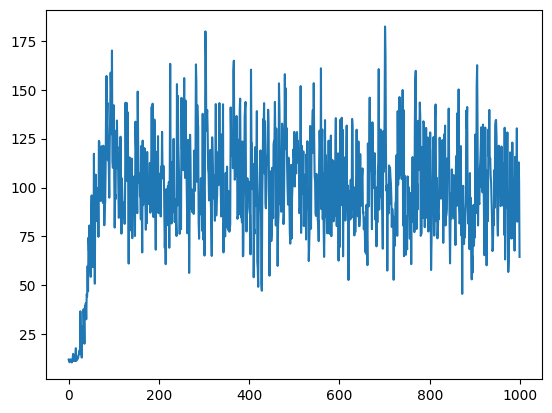

In [ ]:
b = np.array(b)
plt.plot(np.mean(b,axis = 0))

In [ ]:
def q_learning_fa(W,num_episodes,epsilon,gamma,alpha):

  num_bins = 10
  num_actions = 2

  rewards_episodes = []
  for episode in (range(num_episodes)):

    state = env2.reset()[0]
    done = False
    rewards = 0
    while not done:

      action = eps_greedy_policy(W, state, epsilon)
      next_state,reward,done1,done2,info = env2.step(action)

      done = done1 or done2

      next_qs = one_hot_encode(state).dot(W)
      next_v = np.max(next_qs)
      target = reward + gamma*(1 - done1)*next_v
      phi_x = one_hot_encode(state)
      q = phi_x.dot(W)[action]
      dw = (q - target)*phi_x
      W[:,action] -= alpha*dw

      state = next_state
      rewards += reward
    rewards_episodes.append(rewards)
  return W,rewards_episodes


In [ ]:
num_runs = 10
num_bins = 10
num_actions = 2
num_episodes = 1000
epsilon = 0.01
gamma = 0.5
# dicti_Q_learning = {}

rewards_runs = []
for run in tqdm(range(num_runs)):

  np.random.seed(run)
  W = np.random.uniform(-0.001,0.001,size=(4*num_bins,num_actions))
  W,rewards_train = q_learning_fa(W,num_episodes,epsilon,gamma,alpha)
  rewards_runs.append(rewards_train)
dicti_Q_learning[str((alpha,epsilon))] = rewards_runs





100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


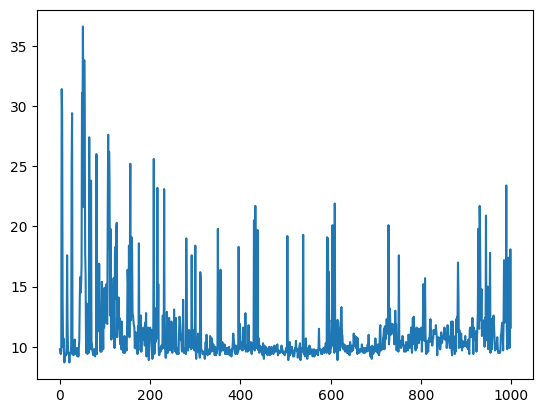

In [ ]:
rewards = np.mean(rewards_runs,axis = 0)
plt.plot(rewards)


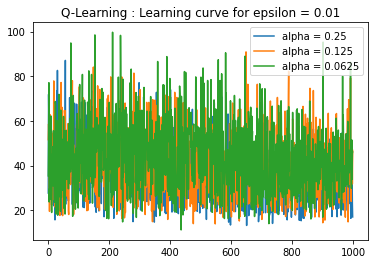

In [ ]:
epsilon = 0.01
# plot the different plots for epsilon = 0.01
for alpha in [1/4,1/8,1/16]:
  k = dicti_Q_learning[str((alpha,epsilon))]
  k = np.mean(k,axis = 0)
  plt.plot(k,label = 'alpha = {}'.format(alpha))
plt.title("Q-Learning : Mean Learning curve for epsilon = {}".format(epsilon))
plt.xlabel("episodes")
plt.ylabel("reward")
plt.legend()
plt.show()

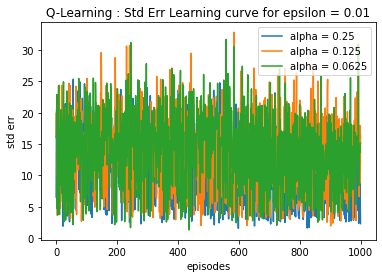

In [ ]:
epsilon = 0.01
# plot the different plots for epsilon = 0.01
for alpha in [1/4,1/8,1/16]:
  k = dicti_Q_learning[str((alpha,epsilon))]
  k = np.std(k,axis = 0)/np.sqrt(10)
  plt.plot(k,label = 'alpha = {}'.format(alpha))
plt.title("Q-Learning : Std Err Learning curve for epsilon = {}".format(epsilon))
plt.xlabel("episodes")
plt.ylabel("std err")
plt.legend()
plt.show()


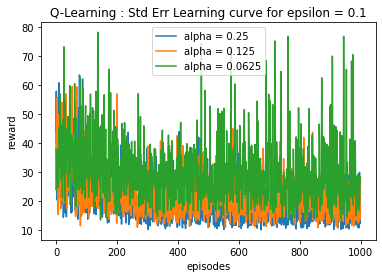

In [ ]:
epsilon = 0.1
# plot the different plots for epsilon = 0.01
for alpha in [1/4,1/8,1/16]:
  k = dicti_Q_learning[str((alpha,epsilon))]
  k = np.mean(k,axis = 0)
  plt.plot(k,label = 'alpha = {}'.format(alpha))
plt.title("Q-Learning : Mean Learning curve for epsilon = {}".format(epsilon))
plt.xlabel("episodes")
plt.ylabel("std err")
plt.legend()
plt.show()

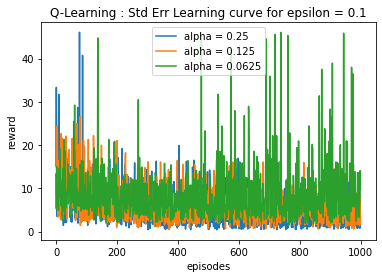

In [ ]:
epsilon = 0.1
# plot the different plots for epsilon = 0.01
for alpha in [1/4,1/8,1/16]:
  k = dicti_Q_learning[str((alpha,epsilon))]
  k = np.std(k,axis = 0)/np.sqrt(10)
  plt.plot(k,label = 'alpha = {}'.format(alpha))
plt.title("Q-Learning : Std Err Learning curve for epsilon = {}".format(epsilon))
plt.xlabel("episodes")
plt.ylabel("reward")
plt.legend()
plt.show()

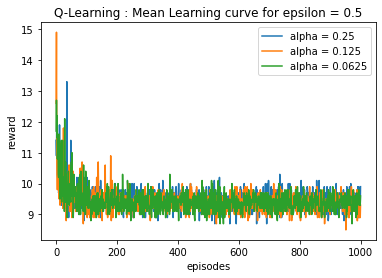

In [ ]:
epsilon = 0.5
# plot the different plots for epsilon = 0.01
for alpha in [1/4,1/8,1/16]:
  k = dicti_Q_learning[str((alpha,epsilon))]
  k = np.mean(k,axis = 0)
  plt.plot(k,label = 'alpha = {}'.format(alpha))
plt.title("Q-Learning : Mean Learning curve for epsilon = {}".format(epsilon))
plt.xlabel("episodes")
plt.ylabel("reward")
plt.legend()
plt.show()

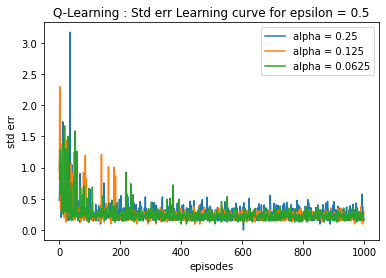

In [ ]:
epsilon = 0.5
# plot the different plots for epsilon = 0.01
for alpha in [1/4,1/8,1/16]:
  k = dicti_Q_learning[str((alpha,epsilon))]
  k = np.std(k,axis = 0)/np.sqrt(10)
  plt.plot(k,label = 'alpha = {}'.format(alpha))
plt.title("Q-Learning : Std err Learning curve for epsilon = {}".format(epsilon))
plt.xlabel("episodes")
plt.ylabel("std err")
plt.legend()
plt.show()

**The choice of returns**
Here it is obvious to want to keep the sum of the returns since it represents the number of step that the pole stays balanced in the car. The higher the sum of the reward the longer the pole stays baanced in the car
 **Q Learning Performances**
The previous performances are far from being ideal since in none of them we see a good learning curve. This can be due to several factors, maybe what is needed is a longer number of episodes, or maybe we need to add decay factors for both epsilon and alpha.

However, one has to notice that epsilon = 0.01 gives the best performance. and the worst one is given by epsilon = 0.5. Indeed with epsilon 0.01 it is like if the greedy choice of action is always the one that is chosen.


The standard error is the lowest for epsilon = 0.5 this can be a factor that indicates that the algorithm does not learn indeed and has a stable value of return.

However, we can see that the lowest alpha (learning rate) always gets the best results, this could be due to the fact that the global extrem is not very far from the initial state.

**Actor Critic**



In [ ]:
def actor_critic(num_episodes,w_critic,theta_actor,alpha_critic,alpha_actor,gamma,temperature):
  rewards = []

  for episode in tqdm(range(num_episodes)):
    state = env2.reset()[0]
    state = one_hot_encode(state)
    done = False
    rewards_per_ep = []
    while not done:

      action = boltzmann_exploration_w(theta_actor,state,temperature)
      next_state, reward, done1, done2 ,_ = env2.step(action)
      next_state = one_hot_encode(next_state)
      done = done1 or done2

      #calculate the error.
      error = reward + gamma*(np.dot(np.transpose(w_critic),next_state)) - np.dot(np.transpose(w_critic),state)

      #calcul the derivative of log_theta(\pi)
      q_state = np.dot(np.transpose(theta_actor),state)
      Z = q_state/temperature - np.max(q_state/temperature) #to stabilize
      exp_values = np.exp(Z)
      pi = exp_values / np.sum(exp_values)
      deriv = state - theta_actor[:,0]*pi[0] - theta_actor[:,1]*pi[1]


      #update w and theta
      w_critic = [w_critic[i] + alpha_critic*error*state[i] for i in range(len(w_critic))]
      theta_actor[:,action] = theta_actor[:,action] + alpha_actor*error*deriv

      state = next_state
      rewards_per_ep.append(reward)

    rewards.append(sum(rewards_per_ep))

  return w_critic,theta_actor,rewards






In [ ]:
temperature = 0.001
number_of_runs = 10
dict_actor_critic = {}
for alpha in [1/4,1/8,1/16]:
  rewards_per_run = []
  for run in range(number_of_runs):
    np.random.seed(run)
    w_critic = np.random.uniform(-0.001,0.001,size=(num_bins**4,1))
    theta_actor = np.random.uniform(-0.001,0.001,size=(num_bins**4,num_actions))
    w,t,rewards = actor_critic(1000,w_critic,theta_actor,alpha_critic = 1/4,alpha_actor = 1/4,gamma=0.99,temperature=0.01)
    rewards_runs_train.append(rewards)
    dict_actor_critic[str(alpha)] = rewards

  1%|▏         | 14/1000 [00:17<20:59,  1.28s/it]


KeyboardInterrupt: ignored

In [ ]:
# plot the mean learning curves

for alpha in [1/4,1/8,1/16]:
  plt.plot(np.mean(dict_actor_critic[str(alpha)],axis = 0),label = "alpha = {}".format(alpha)))
plt.title("Actor Critic Learning curve Mean")


In [ ]:
for alpha in [1/4,1/8,1/16]:
  plt.plot(np.std(dict_actor_critic[str(alpha)],axis = 0)/np.sqrt(10),label = "alpha = {}".format(alpha)))
plt.title("Actor Critic Learning curve Mean")

Once again for the Actor Critic the Learning is hard to be perceived from the curves. And the issue could be resolved by adding some decay factor to alpha (learning rate)